<a href="https://colab.research.google.com/github/pedrobslima/projeto-ciencia-de-dados/blob/main/desmatamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Ciência de Dados

Pedro Barros de Souza Lima - pbsl@cin.ufpe.br

Dataset encontrado em: https://dados.gov.br/dados/conjuntos-dados/incendios-em-unidades-de-conservacao-federais



###**Objetivos:**

1. Coletar dados	✅

2.	Realizar pré-processamento dos dados:
  * Definição	de	tipos ✅
  * Tratamento	de	dados	ausentes ✅
  * Normalização	e	discretização
  * Limpeza	de	dados	(univariado,	bivariado	e	multivariado)

3.	Apresentar estatísticas descritivas	dos	dados com	visualizações

4.	Realizar teste	de	hipóteses para comparação de	valores	de	categorias	(ex.	preço	m2 em diferentes bairros)	e	visualizar diferenças
* Bônus:
  * Integrar	dados	ou extrair	dados	da	Web
  * Utilizar técnicas não cobertas nas aulas

### Imports

In [336]:
import requests
#from http.client import responses
#from os.path import dirname
#from os import environ
#import inspect
#import json
#import gzip
import pandas as pd
import numpy as np
from math import log10
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
#from time import sleep

### Funções

In [2]:
def analiseTipos(df:pd.DataFrame, feature:str = None):
  '''Para printar uma contagem dos tipos, incluindo valores <NAN>
  Caso o parâmentro "feature" não seja declarado, será feito o .dtypes do dataframe "df"'''
  if(feature):
    print(f'''Num <NAN>: {len(df[df[feature].isna()])}

{df[feature].apply(lambda x: type(x)).value_counts()}''')
  else:
    print(f'Num <NAN>: {len(df[df.isna()])}\n')
    print(df.dtypes)

## Pré-análise dos dados

Coleta dos dados principais:

In [3]:
df = pd.read_excel('/content/tabela_de_desmatamento_ucs.xlsx', sheet_name=0, header=1)
df = df.drop(df.index[-1])
df = df.assign(bioma = "Amazônia")
for b in ['Mata Atlântica', 'Pampa', 'Cerrado', 'Caatinga']: # tirei o pantanal porque dados estavam incompletos
  temp = pd.read_excel('/content/tabela_de_desmatamento_ucs.xlsx', sheet_name=b, header=1)
  temp = temp.drop(temp.index[-1])
  temp = temp.assign(bioma = b)
  df = pd.concat([df, temp], ignore_index=True)

In [4]:
df.columns

Index([                  'cnuc', 'unidade de conservação',
                   'área_ha_uc',               'Até 2007',
                           2008,                     2009,
                           2010,                     2011,
                           2012,                     2013,
                           2014,                     2015,
                           2016,                     2017,
                           2018,                     2019,
                           2020,                     2021,
                           2022,                     2023,
                        'TOTAL',                  'bioma',
                     'Até 2000',            '2001 a 2004',
                           2006,                     2002,
                           2004],
      dtype='object')

---
### Verificação da coluna 'TOTAL' e remoção de registros pré-2008


In [5]:
cols = ['Até 2007', 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
        2018, 2019, 2020, 2021, 2022, 2023, 'Até 2000', '2001 a 2004', 2006, 2002, 2004]

df.assign(total_check=lambda x: x.loc[:,cols].sum(axis=1))[['unidade de conservação', 'bioma', 'TOTAL', 'total_check']]

,unidade de conservação,bioma,TOTAL,total_check
0,APA do Igarapé Gelado,Amazônia,9146.70,9146.70
1,APA do Tapajós,Amazônia,137537.01,137537.01
2,APA dos Campos de Manicoré,Amazônia,215.43,215.43
3,ARIE Projeto Dinâmica Biológica de Fragmento F...,Amazônia,74.26,74.26
4,ARIE Seringal Nova Esperança,Amazônia,1777.85,1777.85
...,...,...,...,...
316,REBIO Guaribas,Caatinga,20.16,20.16
317,RESEX do Batoque,Caatinga,105.36,105.36
318,RESEX Prainha do Canto Verde,Caatinga,72.90,72.90
319,REVIS da Ararinha Azul,Caatinga,111.72,111.72


Se você for comparar os valores da soma e do TOTAL, pelo pandas vai dizer que alguns não são iguais, mas se compararmos visualmente, claramente não há diferença. Provavelmente é uma diferença na leitura dos floats ou na computação da soma. Não há diferenças relevantes.

In [6]:
df = df.drop(columns=['Até 2007', '2001 a 2004', 'Até 2000', 2002, 2006, 2004])

In [7]:
df

,cnuc,unidade de conservação,área_ha_uc,2008,2009,2010,2011,2012,2013,2014,...,2016,2017,2018,2019,2020,2021,2022,2023,TOTAL,bioma
0,0000.00.0022,APA do Igarapé Gelado,2.071467e+04,119.53,0.00,5.15,0.00,0.00,10.63,0.00,...,0.09,0.00,0.00,9.81,23.75,7.68,14.29,0.00,9146.70,Amazônia
1,0000.00.0268,APA do Tapajós,2.040336e+06,1648.94,1523.54,829.74,1352.57,2238.81,3246.37,2872.94,...,3143.69,3229.61,3895.20,6552.78,6963.76,10646.08,11140.01,4879.10,137537.01,Amazônia
2,0000.00.3407,APA dos Campos de Manicoré,1.521325e+05,0.00,24.53,4.32,16.52,0.00,0.00,0.00,...,11.59,26.83,11.19,40.52,0.00,20.45,29.66,1.71,215.43,Amazônia
3,0000.00.0043,ARIE Projeto Dinâmica Biológica de Fragmento F...,3.336296e+03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,74.26,Amazônia
4,0000.00.0044,ARIE Seringal Nova Esperança,2.573984e+03,13.01,25.32,28.75,34.40,222.00,26.89,132.50,...,78.45,61.09,55.34,70.91,57.78,119.10,61.31,90.59,1777.85,Amazônia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,0000.00.0196,REBIO Guaribas,4.051657e+03,0.39,NaN,0.00,0.00,NaN,0.00,0.00,...,0.11,0.00,0.00,0.00,0.00,0.00,0.00,NaN,20.16,Caatinga
317,0000.00.0231,RESEX do Batoque,6.014409e+02,0.00,NaN,14.70,0.00,NaN,5.94,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,105.36,Caatinga
318,0000.00.1809,RESEX Prainha do Canto Verde,2.980527e+04,0.00,NaN,30.13,0.00,NaN,0.00,0.00,...,2.89,0.00,0.00,12.68,0.00,0.00,0.00,NaN,72.90,Caatinga
319,0000.00.3694,REVIS da Ararinha Azul,2.923449e+04,7.68,NaN,17.78,0.00,NaN,19.26,9.08,...,3.65,0.00,0.00,6.27,4.79,3.23,0.00,NaN,111.72,Caatinga


---
### Verificação de Unidades de Conservação (UC) duplicadas

In [8]:
(df['unidade de conservação'].value_counts() > 1).sum()

17

In [9]:
cols = ['unidade de conservação', 'bioma']
df.loc[:,cols].groupby(by='unidade de conservação').aggregate('count').sort_values(by='bioma', ascending=False).head(18)

,bioma
unidade de conservação,
PARNA Cavernas do Peruaçu,2
APA das Ilhas e Várzeas do Rio Paraná,2
PARNA Serra de Itabaiana,2
RESEX do Ciriaco,2
APA da Barra do Rio Mamanguape,2
REBIO Guaribas,2
PARNA de Boa Nova,2
FLONA de Capão Bonito,2
PARNA da Serra das Confusões,2


UCs repetidas são compostas por 2 biomas.

In [10]:
df.head()

,cnuc,unidade de conservação,área_ha_uc,2008,2009,2010,2011,2012,2013,2014,...,2016,2017,2018,2019,2020,2021,2022,2023,TOTAL,bioma
0,0000.00.0022,APA do Igarapé Gelado,2.071467e+04,119.53,0.00,5.15,0.00,0.00,10.63,0.00,...,0.09,0.00,0.00,9.81,23.75,7.68,14.29,0.00,9146.70,Amazônia
1,0000.00.0268,APA do Tapajós,2.040336e+06,1648.94,1523.54,829.74,1352.57,2238.81,3246.37,2872.94,...,3143.69,3229.61,3895.20,6552.78,6963.76,10646.08,11140.01,4879.10,137537.01,Amazônia
2,0000.00.3407,APA dos Campos de Manicoré,1.521325e+05,0.00,24.53,4.32,16.52,0.00,0.00,0.00,...,11.59,26.83,11.19,40.52,0.00,20.45,29.66,1.71,215.43,Amazônia
3,0000.00.0043,ARIE Projeto Dinâmica Biológica de Fragmento F...,3.336296e+03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,74.26,Amazônia
4,0000.00.0044,ARIE Seringal Nova Esperança,2.573984e+03,13.01,25.32,28.75,34.40,222.00,26.89,132.50,...,78.45,61.09,55.34,70.91,57.78,119.10,61.31,90.59,1777.85,Amazônia


In [11]:
#cols = ['unidade de conservação', 'TOTAL', 'bioma']
#df.loc[:,cols].groupby(by=['unidade de conservação', 'TOTAL']).aggregate('count').sort_values(by='bioma', ascending=False).head(18)
df[df['unidade de conservação'] == 'PARNA Cavernas do Peruaçu']

,cnuc,unidade de conservação,área_ha_uc,2008,2009,2010,2011,2012,2013,2014,...,2016,2017,2018,2019,2020,2021,2022,2023,TOTAL,bioma
259,0000.00.0135,PARNA Cavernas do Peruaçu,56448.64549,8.68,NaN,26.68,NaN,75.26,7.09,1.01,...,0.00,10.12,12.59,0.00,0.0,0.00,0.0,NaN,907.26,Cerrado
303,0000.00.0135,PARNA Cavernas do Peruaçu,56448.64549,142.74,NaN,86.69,4.96,NaN,241.22,82.60,...,78.57,41.40,61.49,13.29,5.1,15.49,0.0,NaN,3494.64,Caatinga


É importante deixá-las como instâncias separadas porque a área desmatada é diferente entre biomas da mesma UC.

---
### Coleta & Integração das Unidades Federativas ao dataset principal
(+ rápida análise + remoção de duplicatas)


In [12]:
dfid = pd.read_excel('/content/dados-do-samge-1-identificacao-e-resultados.xlsx').loc[:,['Nome da UC', 'UF']]

In [13]:
dfid.head()

,Nome da UC,UF
0,APA ANHATOMIRIM,SC
1,APA CAVERNAS DO PERUAÇU,MG
2,APA DA BACIA DO RIO DESCOBERTO,"DF, GO"
3,APA DA BACIA DO RIO SÃO BARTOLOMEU,DF
4,APA DA BACIA DO RIO SÃO JOÃO - MICO LEÃO,RJ


In [14]:
dfid['Nome da UC'].value_counts()

Nome da UC
FLONA DE TRÊS BARRAS            6
PARNA DE BRASÍLIA               6
PARNA DE ILHA GRANDE            6
PARNA DE SAINT-HILAIRE/LANGE    6
PARNA DE SÃO JOAQUIM            6
                               ..
APA BAÍA NEGRA                  1
FE DO RIO LIBERDADE             1
FE DO RIO GREGÓRIO              1
FE DO MOGNO                     1
PNM FAZENDA DO CARMO            1
Name: count, Length: 779, dtype: int64

In [15]:
dfid[dfid['Nome da UC'] == 'FLONA DE TRÊS BARRAS']

,Nome da UC,UF
124,FLONA DE TRÊS BARRAS,SC
769,FLONA DE TRÊS BARRAS,SC
1415,FLONA DE TRÊS BARRAS,SC
1951,FLONA DE TRÊS BARRAS,SC
2459,FLONA DE TRÊS BARRAS,SC
2774,FLONA DE TRÊS BARRAS,SC


In [16]:
print(len(dfid))
len(dfid.drop_duplicates())

2907


779

Não foi apresentado aqui no código, mas na planilha original, a diferença entre essas duplicatas são apenas o ano do registro, que é importante para dados referentes ao gerenciamento das UCs.

Como nós só precisamos do(s) estado(s) onde estão localizadas, não tem porquê manter essas duplicatas:  

In [17]:
dfid = dfid.drop_duplicates()
df['unidade de conservação'] = df['unidade de conservação'].apply(lambda x: x.upper())
df = pd.merge(df, dfid, how='inner', right_on='Nome da UC', left_on='unidade de conservação').drop(columns=['Nome da UC'])
df[df['unidade de conservação'] == 'APA DA BACIA DO RIO DESCOBERTO']

,cnuc,unidade de conservação,área_ha_uc,2008,2009,2010,2011,2012,2013,2014,...,2017,2018,2019,2020,2021,2022,2023,TOTAL,bioma,UF
168,0000.00.0003,APA DA BACIA DO RIO DESCOBERTO,36159.770194,121.38,NaN,81.63,NaN,48.05,25.85,241.22,...,47.46,39.52,6.13,16.94,29.47,10.97,NaN,29053.02,Cerrado,"DF, GO"


---
### Definição de tipos

In [18]:
df.dtypes

cnuc                       object
unidade de conservação     object
área_ha_uc                float64
2008                      float64
2009                      float64
2010                      float64
2011                      float64
2012                      float64
2013                      float64
2014                      float64
2015                      float64
2016                      float64
2017                      float64
2018                      float64
2019                      float64
2020                      float64
2021                      float64
2022                      float64
2023                      float64
TOTAL                     float64
bioma                      object
UF                         object
dtype: object

In [19]:
df['cnuc'].nunique() == df['unidade de conservação'].nunique()

True

In [20]:
print(df['UF'].unique())
df['UF'].nunique()

['PA' 'AM' 'AC' 'AM, RO' 'RR' 'AP, PA' 'RO' 'AM, PA' 'AP' 'AM, MT'
 'AM, MT, RO' 'AM, RR' 'MA' 'SC' 'ES' 'RJ' 'PR' 'MG' 'SP' 'RS' 'AL' 'RN'
 'SE' 'RJ, SP' 'BA' 'RS, SC' 'MS, PR' 'AL, PE' 'PE' 'PB' 'DF, GO' 'DF'
 'GO' 'CE, PI' 'TO' 'MT' 'PI' 'BA, TO' 'MS' 'CE']


40

In [21]:
print(df.loc[:,'UF'][df['UF'].str.len() == 2].unique())
df.loc[:,'UF'][df['UF'].str.len() == 2].nunique()

['PA' 'AM' 'AC' 'RR' 'RO' 'AP' 'MA' 'SC' 'ES' 'RJ' 'PR' 'MG' 'SP' 'RS'
 'AL' 'RN' 'SE' 'BA' 'PE' 'PB' 'DF' 'GO' 'TO' 'MT' 'PI' 'MS' 'CE']


27

Todos os estados estão listados

In [26]:
df.loc[:,'UF'][df['UF'].str.len() > 2].value_counts()

UF
DF, GO        4
AM, RO        2
AP, PA        2
RS, SC        2
CE, PI        2
AM, PA        1
AM, MT        1
AM, MT, RO    1
AM, RR        1
RJ, SP        1
MS, PR        1
AL, PE        1
BA, TO        1
Name: count, dtype: int64

In [79]:
co = ['AL', 'PE', 'PB', 'RN', 'SE', 'CE', 'PI', 'MA', 'BA', # NE  (1) 0-8
      'TO', 'PA', 'AC', 'RR', 'RO', 'AP', 'AM',             # N   (1) 9-15
      'MT', 'MS', 'DF', 'GO',                               # CO  (1) 16-19
      'PR', 'RS', 'SC',                                     # S   (1) 20-22
      'ES', 'RJ', 'MG', 'SP',                               # SE  (1) 23-26
      'AL, PE', 'CE, PI',                     # NE      (2) 27-28
      'BA, TO',                               # NE, N   (2) 29
      'AM, RO', 'AM, PA', 'AM, RR', 'AP, PA', # N       (2) 30-33
      'AM, MT', 'AM, MT, RO',                 # N, CO   (2)(3) 34-35
      'DF, GO',                               # CO      (2) 36
      'MS, PR',                               # CO, S   (2) 37
      'RS, SC',                               # S       (2) 38
      'RJ, SP'                                # SE      (2) 39
      ]

df['UF'] = df['UF'].astype(pd.api.types.CategoricalDtype(categories=co))

Não acho que vale a pena aumentar o número de UCs para que cada instância tenha apenas uma UF relacionada. Elas já foram dividas de acordo com seus biomas, além disso, não temos como relacionar um bioma a um estado exclusivamente porque biomas não respeitam fronteiras artificiais.

In [23]:
df['bioma'].unique(), df['bioma'].nunique()

(array(['Amazônia', 'Cerrado', 'Mata Atlântica', 'Caatinga', 'Pampa'],
       dtype=object),
 5)

In [24]:
df['bioma'] = df['bioma'].astype('category')
df['bioma'].cat.categories

Index(['Amazônia', 'Caatinga', 'Cerrado', 'Mata Atlântica', 'Pampa'], dtype='object')

In [25]:
#df['bioma'] = df['bioma'].cat.codes

Criação da coluna "região":

In [75]:
df[df['UF'].isin(['BA, TO', 'AM, MT', 'AM, MT, RO', 'MS, PR'])]

,cnuc,unidade de conservação,área_ha_uc,2008,2009,2010,2011,2012,2013,2014,...,2018,2019,2020,2021,2022,2023,TOTAL,bioma,UF,região
43,0000.00.0281,PARNA DO JURUENA,1.957028e+06,363.50,0.00,62.79,79.32,7.30,35.90,0.00,...,10.09,48.89,38.14,70.40,41.94,99.16,10948.16,Amazônia,"AM, MT","N, CO"
47,0000.00.0284,PARNA DOS CAMPOS AMAZÔNICOS,9.613137e+05,385.13,71.51,17.94,139.62,48.76,192.89,0.00,...,37.75,197.04,514.00,735.05,363.06,182.31,7015.26,Amazônia,"AM, MT, RO","N, CO"
132,0000.00.0161,PARNA DE ILHA GRANDE,7.613765e+04,31.33,NaN,0.00,9.25,NaN,18.49,0.00,...,4.85,12.09,8.09,0.00,14.80,NaN,362.80,Mata Atlântica,"MS, PR","CO, S"
178,0000.00.0076,ESEC SERRA GERAL DO TOCANTINS,7.070848e+05,289.34,NaN,4.64,NaN,10.33,30.61,115.32,...,0.00,1.19,16.96,6.94,2.38,NaN,2136.71,Cerrado,"BA, TO","NE, N"


Apenas 4 UCs estão presentes em mais de uma região.

In [105]:
uf2reg = ['NE', 'N', 'CO', 'S', 'SE', 'NE', 'NE, N', 'N', 'N, CO', 'CO', 'CO, S', 'S', 'SE']

df['região'] = pd.cut(df.UF.cat.codes, [0, 9, 16, 20, 23, 27, 29, 30, 34, 36, 37, 38, 39, 40], ordered=False, labels=uf2reg, right=False)

# Define and apply arbitrary category order
# Essa ordem foi decidida porque se quiser fazer uma análise de bioma presentes
# nas regiões, por exemplo, Norte e/ou Centro-Oeste, é só especificar o intervalo
# dos índices de ambas as regiões, que também irá incluir UCs presentes em ambas
# ao mesmo tempo, df['região'].cat.categories[1:4] => ['N', 'N, CO', 'CO'],
# ou até df['região'].cat.categories[3:6] => ['N', 'N, CO', 'CO']
co = ['NE', 'NE, N', 'N', 'N, CO', 'CO', 'CO, S', 'S', 'SE']

df['região'] = df['região'].astype(pd.api.types.CategoricalDtype(categories=co))

df['região'].value_counts()

região
N        82
NE       57
SE       38
S        27
CO       12
N, CO     2
CO, S     1
NE, N     1
Name: count, dtype: int64

In [106]:
df[df['região'].isin(df['região'].cat.categories[3:6])]

,cnuc,unidade de conservação,área_ha_uc,2008,2009,2010,2011,2012,2013,2014,...,2018,2019,2020,2021,2022,2023,TOTAL,bioma,UF,região
43,0000.00.0281,PARNA DO JURUENA,1.957028e+06,363.50,0.00,62.79,79.32,7.30,35.90,0.00,...,10.09,48.89,38.14,70.40,41.94,99.16,10948.16,Amazônia,"AM, MT","N, CO"
47,0000.00.0284,PARNA DOS CAMPOS AMAZÔNICOS,9.613137e+05,385.13,71.51,17.94,139.62,48.76,192.89,0.00,...,37.75,197.04,514.00,735.05,363.06,182.31,7015.26,Amazônia,"AM, MT, RO","N, CO"
55,0000.00.0207,REBIO DO GURUPI,2.714651e+05,3648.27,2761.69,1161.74,666.21,833.65,663.34,50.21,...,368.14,315.77,338.75,495.03,445.94,313.98,82307.54,Amazônia,MA,NE
62,0000.00.3654,RESEX ARAPIRANGA-TROMAÍ,1.869363e+05,0.00,0.00,0.00,0.00,9.35,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,NaN,2248.02,Amazônia,MA,NE
69,0000.00.3653,RESEX DA BAÍA DO TUBARÃO,2.239274e+05,2.83,1.16,0.71,0.00,0.00,1.45,18.43,...,6.63,12.56,21.23,9.06,0.00,NaN,186.91,Amazônia,MA,NE
70,0000.00.3653,RESEX DA BAÍA DO TUBARÃO,2.239274e+05,0.00,NaN,0.12,NaN,0.00,0.00,7.70,...,0.00,0.00,2.56,2.52,0.00,NaN,217.22,Cerrado,MA,NE
71,0000.00.0279,RESEX DE CURURUPU,1.860535e+05,26.70,2.32,0.00,0.00,0.00,0.00,4.10,...,0.00,0.00,0.00,0.00,0.00,NaN,20841.41,Amazônia,MA,NE
75,0000.00.3651,RESEX ITAPETININGA,1.629402e+04,0.00,7.65,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,NaN,4634.92,Amazônia,MA,NE
99,0000.00.0059,ESEC DE MURICI,6.131573e+03,175.01,NaN,171.16,0.80,NaN,23.63,0.00,...,1.63,1.77,9.33,4.24,0.00,NaN,959.88,Mata Atlântica,AL,NE
111,0000.00.0100,FLONA DE NÍSIA FLORESTA,1.688443e+02,0.00,NaN,0.00,0.00,NaN,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,NaN,0.20,Mata Atlântica,RN,NE


---
###Tratamento de dados ausentes

In [107]:
cols = ['unidade de conservação', 'área_ha_uc', 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023, 'TOTAL', 'bioma']
df[cols].head()

,unidade de conservação,área_ha_uc,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,TOTAL,bioma
0,APA DO IGARAPÉ GELADO,2.071467e+04,119.53,0.00,5.15,0.00,0.00,10.63,0.00,0.00,0.09,0.00,0.00,9.81,23.75,7.68,14.29,0.00,9146.70,Amazônia
1,APA DO TAPAJÓS,2.040336e+06,1648.94,1523.54,829.74,1352.57,2238.81,3246.37,2872.94,3437.89,3143.69,3229.61,3895.20,6552.78,6963.76,10646.08,11140.01,4879.10,137537.01,Amazônia
2,APA DOS CAMPOS DE MANICORÉ,1.521325e+05,0.00,24.53,4.32,16.52,0.00,0.00,0.00,0.00,11.59,26.83,11.19,40.52,0.00,20.45,29.66,1.71,215.43,Amazônia
3,ARIE SERINGAL NOVA ESPERANÇA,2.573984e+03,13.01,25.32,28.75,34.40,222.00,26.89,132.50,89.38,78.45,61.09,55.34,70.91,57.78,119.10,61.31,90.59,1777.85,Amazônia
4,ESEC ALTO MAUÉS,6.665559e+05,0.00,16.64,31.22,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,45.94,5.56,33.46,145.82,56.26,524.67,Amazônia


In [108]:
df.loc[(df[cols].isna().any(axis=1)), cols]

,unidade de conservação,área_ha_uc,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,TOTAL,bioma
48,PARNA DOS CAMPOS FERRUGINOSOS,7.886933e+04,199.46,0.00,13.55,0.00,0.0,0.00,26.16,0.03,105.10,13.18,26.81,0.00,0.00,1.85,0.0,NaN,7084.51,Amazônia
50,PARNA MONTANHAS DO TUMUCUMAQUE,3.865169e+06,0.00,0.00,23.58,0.00,0.0,0.00,0.00,6.67,0.00,9.24,0.00,28.09,20.45,43.28,0.0,NaN,4187.83,Amazônia
51,PARNA NASCENTES DO LAGO JARI,8.085987e+05,0.00,7.52,0.00,9.96,0.0,0.00,0.01,0.00,0.00,0.00,0.00,0.00,2.80,0.00,0.0,NaN,2770.26,Amazônia
52,PARNA SERRA DA MOCIDADE,3.593701e+05,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,NaN,9.07,Amazônia
53,REBIO DO ABUFARI,2.247450e+05,13.39,0.00,69.70,8.53,0.0,18.99,13.84,0.00,10.20,0.00,0.00,0.00,6.39,0.00,0.0,NaN,347.46,Amazônia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,PARNA DO CATIMBAU,6.229488e+04,195.94,NaN,131.77,19.43,NaN,83.71,27.20,NaN,22.05,137.16,34.73,11.34,19.90,25.44,29.1,NaN,12020.38,Caatinga
216,REBIO DE SERRA NEGRA,6.248539e+02,0.00,NaN,0.00,0.00,NaN,0.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.0,NaN,3.81,Caatinga
217,RESEX DO BATOQUE,6.014409e+02,0.00,NaN,14.70,0.00,NaN,5.94,0.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.0,NaN,105.36,Caatinga
218,RESEX PRAINHA DO CANTO VERDE,2.980527e+04,0.00,NaN,30.13,0.00,NaN,0.00,0.00,NaN,2.89,0.00,0.00,12.68,0.00,0.00,0.0,NaN,72.90,Caatinga


In [109]:
df[df['bioma'].cat.codes==1].loc[:,cols]

,unidade de conservação,área_ha_uc,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,TOTAL,bioma
131,PARNA DE BOA NOVA,1.229458e+04,120.50,NaN,28.53,0.00,NaN,63.27,23.42,NaN,21.24,20.36,3.86,16.58,0.00,0.00,0.00,NaN,1568.86,Caatinga
154,REBIO GUARIBAS,4.051657e+03,0.39,NaN,0.00,0.00,NaN,0.00,0.00,NaN,0.11,0.00,0.00,0.00,0.00,0.00,0.00,NaN,20.16,Caatinga
160,REVIS DE BOA NOVA,1.483345e+04,32.18,NaN,14.57,0.00,NaN,1.31,0.00,NaN,27.94,0.00,0.00,1.53,0.00,0.00,12.59,NaN,1670.72,Caatinga
167,APA CAVERNAS DO PERUAÇU,1.152097e+05,71.32,NaN,155.47,0.00,NaN,222.36,25.47,NaN,75.00,1.86,7.49,9.25,10.51,15.40,1.70,NaN,6192.45,Caatinga
173,APA SERRA DA IBIAPABA,1.622418e+06,15344.82,NaN,19106.54,3364.89,NaN,6512.01,3857.47,NaN,4776.62,4106.88,1914.27,2076.97,2014.73,2291.21,2430.24,NaN,241266.31,Caatinga
183,PARNA CAVERNAS DO PERUAÇU,5.644865e+04,142.74,NaN,86.69,4.96,NaN,241.22,82.60,NaN,78.57,41.40,61.49,13.29,5.10,15.49,0.00,NaN,3494.64,Caatinga
198,APA DA ARARINHA AZUL,9.064078e+04,46.90,NaN,1.64,2.36,NaN,70.91,1.31,NaN,17.81,3.67,21.90,37.33,7.09,18.62,53.29,NaN,897.56,Caatinga
199,APA DO BOQUEIRÃO DA ONÇA,5.056454e+05,558.16,NaN,126.73,792.08,NaN,297.65,96.47,NaN,206.82,108.89,292.01,123.65,106.28,1203.61,903.17,NaN,41967.69,Caatinga
200,APA SERRA DA MERUOCA,2.936154e+04,421.69,NaN,277.00,39.83,NaN,248.37,145.75,NaN,154.37,78.22,13.25,34.78,9.11,15.57,47.87,NaN,6676.99,Caatinga
201,ESEC DE AIUABA,1.174692e+04,24.68,NaN,19.65,9.41,NaN,14.57,1.45,NaN,17.01,7.44,14.92,9.80,52.89,2.71,6.22,NaN,972.82,Caatinga


In [110]:
df.loc[:,2023].isna().sum() / len(df)

0.7181818181818181

Aproximadamente 72% dos registros de 2023 são nulos, será que devo remover?

In [148]:
dfna = pd.DataFrame(index=df.bioma.cat.categories, columns=range(2008,2024))
dfna = dfna.transform(lambda x: [df.loc[(df.bioma==x.name), col].isna().sum() for col in range(2008,2024)], axis=1)
dfna = dfna.assign(num_total=lambda x: df.bioma.value_counts())
dfna

,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,num_total
Amazônia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,87
Caatinga,0,28,0,0,28,0,0,28,0,0,0,0,0,0,0,28,28
Cerrado,0,33,0,33,0,0,0,0,0,0,0,0,0,0,0,33,33
Mata Atlântica,0,70,0,0,70,0,0,70,0,0,0,0,0,0,0,70,70
Pampa,0,2,0,0,2,0,0,2,0,0,0,0,0,0,0,2,2


Colunas NAN por biomas:
* Amazônia:
  * Any NAN: 2023 (25NAN x 62NUM)
  * All NAN:
* Caatinga:
  * Any NAN: 2009, 2012, 2015, 2023
  * All NAN: 2009, 2012, 2015, 2023
* Cerrado:
  * Any NAN: 2009, 2011, 2023
  * All NAN: 2009, 2011, 2023
* Mata Atlântica:
  * Any NAN: 2009, 2012, 2015, 2023
  * All NAN: 2009, 2012, 2015, 2023
* Pampa:
  * Any NAN: 2009, 2012, 2015, 2023
  * All NAN: 2009, 2012, 2015, 2023

In [197]:
df['bioma'].cat.categories

Index(['Amazônia', 'Caatinga', 'Cerrado', 'Mata Atlântica', 'Pampa'], dtype='object')

Como a maioria das colunas de anos faltantes estão entre colunas com dados declarados, achei melhor que esses dados faltantes fossem substituídos pela média das duas colunas vizinhas, indicando um aumento/diminuição gradual da quantidade de hectares desmatados, ao invés de simplesmente dizer que, por exemplo, não houve desmatamento para todas as UCs do bioma da Pampa no ano de 2009.

In [207]:
cols = [2009, 2012, 2015]
df.loc[(df.bioma.cat.codes.isin([1,3,4])), cols] = df.loc[(df.bioma.cat.codes.isin([1,3,4])), cols].apply(lambda x: (df[(x.name + 1)] + df[(x.name - 1)])/2)
cols = [2009, 2011]
df.loc[(df.bioma.cat.codes==2), cols] = df.loc[(df.bioma.cat.codes==2), cols].apply(lambda x: (df[(x.name + 1)] + df[(x.name - 1)])/2)
#df = df.drop(columns=[2023])

<Axes: >

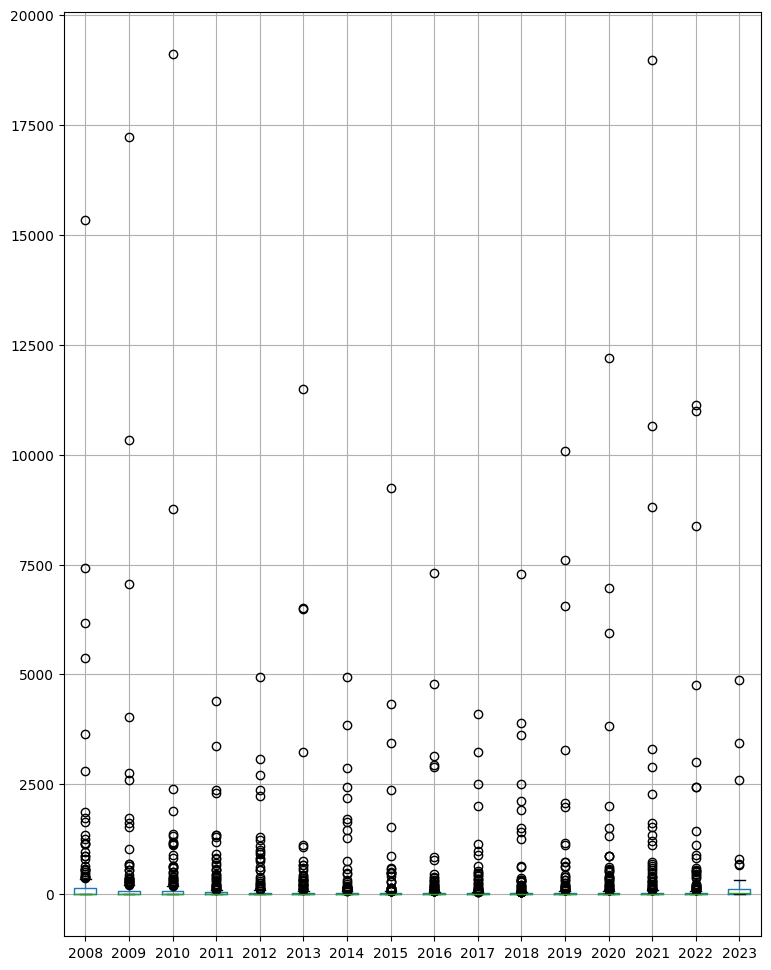

In [209]:
df[range(2008,2024)].boxplot(figsize=(9,12))

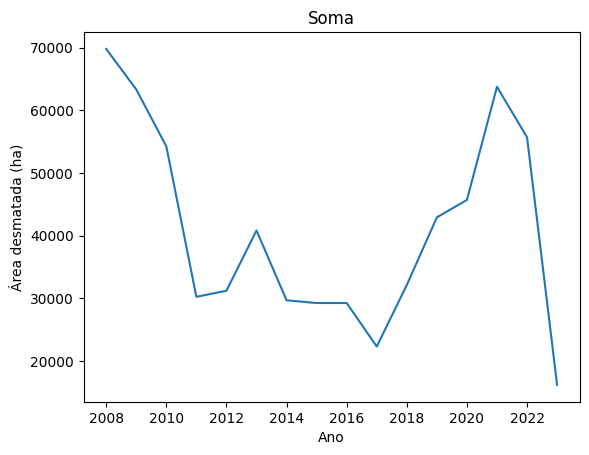

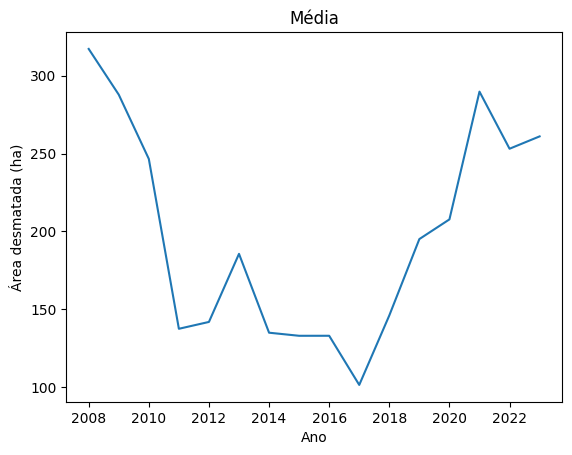

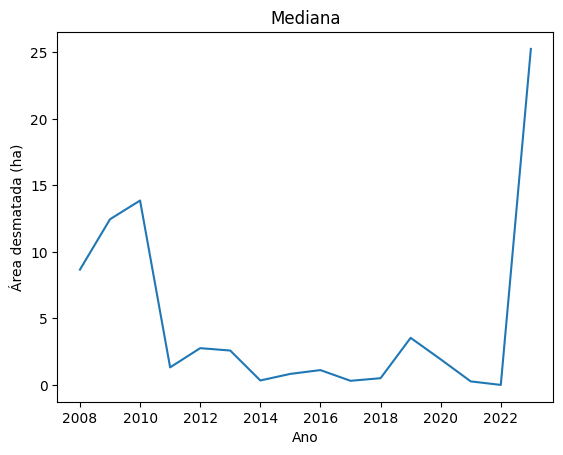

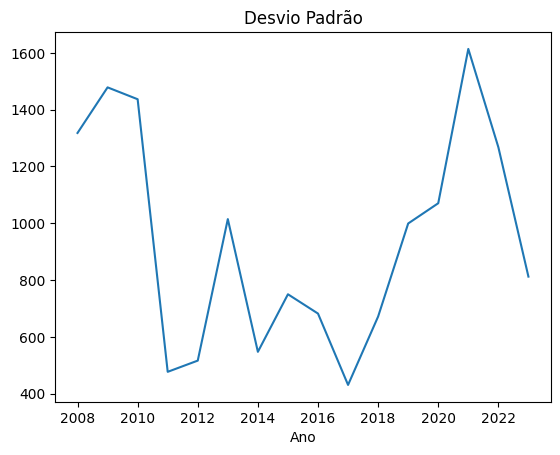

In [211]:
cols = list(range(2008,2024))

plt.title('Soma')
plt.xlabel('Ano')
plt.ylabel('Área desmatada (ha)')
plt.plot(df[cols].sum())
plt.show()

plt.title('Média')
plt.xlabel('Ano')
plt.ylabel('Área desmatada (ha)')
plt.plot(df[cols].mean())
plt.show()

plt.title('Mediana')
plt.xlabel('Ano')
plt.ylabel('Área desmatada (ha)')
plt.plot(df[cols].median())
plt.show()

plt.title('Desvio Padrão')
plt.xlabel('Ano')
#plt.ylabel('Área desmatada (ha)')
plt.plot(df[cols].std())
plt.show()

<Axes: >

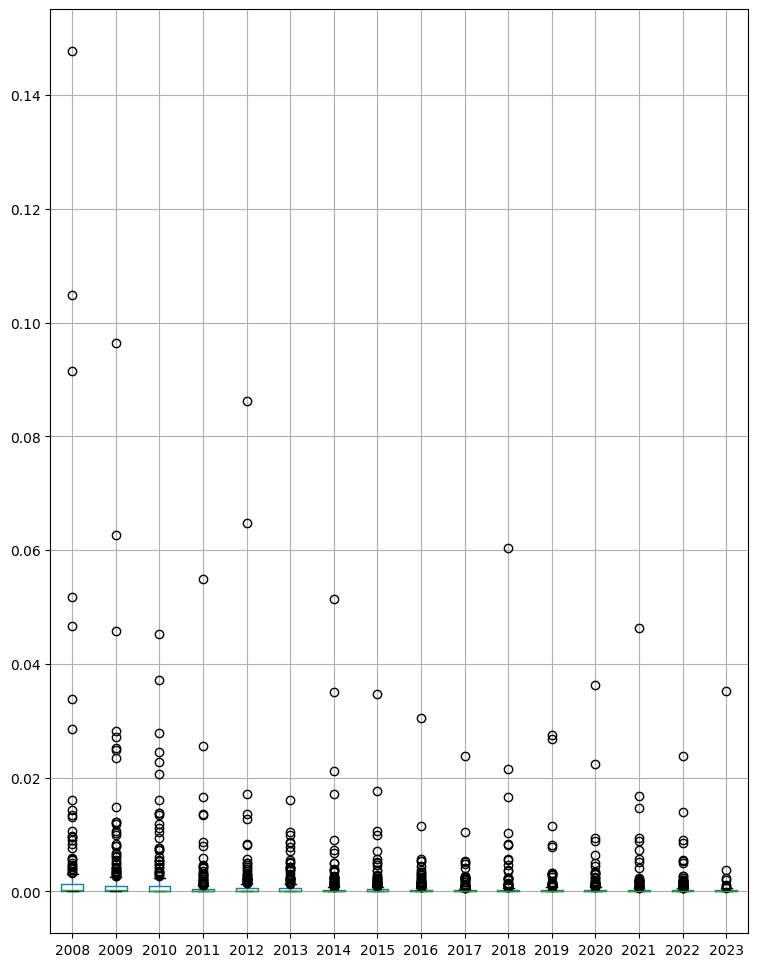

In [212]:
dft = df.copy()
dft.loc[:,range(2008,2024)] = dft.loc[:,range(2008,2024)].apply(lambda x: x/dft['área_ha_uc'])
dft[range(2008,2024)].boxplot(figsize=(9,12))

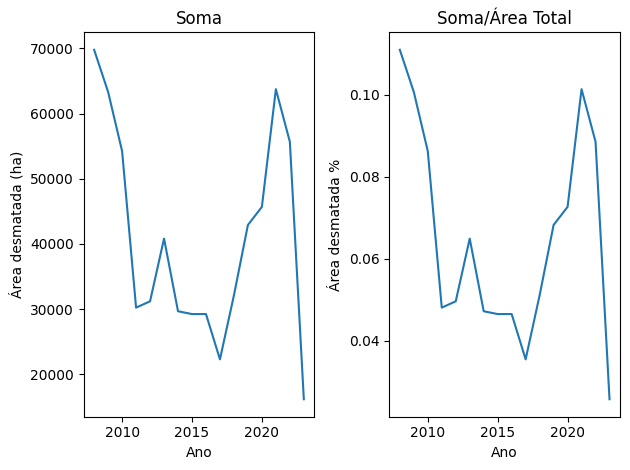

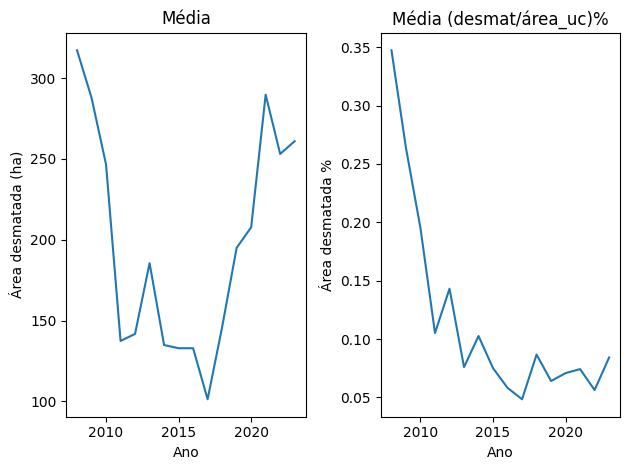

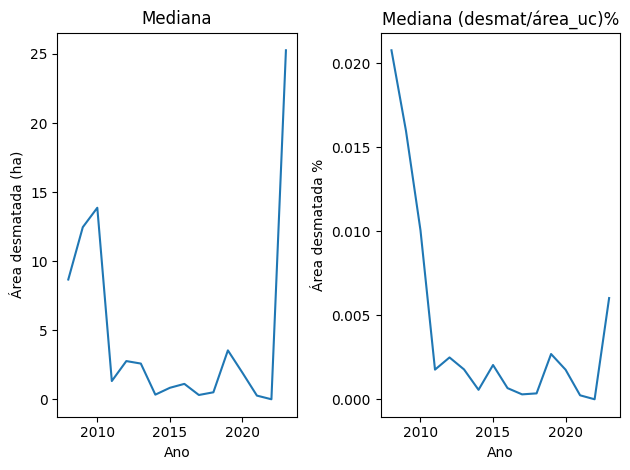

In [213]:
cols = range(2008,2024)

plt.subplot(1, 2, 1)
plt.title('Soma')
plt.xlabel('Ano')
plt.ylabel('Área desmatada (ha)')
plt.plot(df[cols].sum())

plt.subplot(1, 2, 2)
plt.title('Soma/Área Total')
plt.xlabel('Ano')
plt.ylabel('Área desmatada %')
plt.plot(((df[cols]/df['área_ha_uc'].sum()).sum())*100)
plt.tight_layout()
plt.show()

plt.subplot(1, 2, 1)
plt.title('Média')
plt.xlabel('Ano')
plt.ylabel('Área desmatada (ha)')
plt.plot(df[cols].mean())

plt.subplot(1, 2, 2)
plt.title('Média (desmat/área_uc)%')
plt.xlabel('Ano')
plt.ylabel('Área desmatada %')
plt.plot((dft[cols].mean())*100)
plt.tight_layout()
plt.show()

plt.subplot(1, 2, 1)
plt.title('Mediana')
plt.xlabel('Ano')
plt.ylabel('Área desmatada (ha)')
plt.plot(df[cols].median())

plt.subplot(1, 2, 2)
plt.title('Mediana (desmat/área_uc)%')
plt.xlabel('Ano')
plt.ylabel('Área desmatada %')
plt.plot((dft[cols].median())*100)
plt.tight_layout()
plt.show()

In [214]:
df.describe()

,área_ha_uc,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,TOTAL
count,2.200000e+02,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,62.000000,220.000000
mean,2.858424e+05,317.171682,287.801545,246.524409,137.433977,141.828227,185.556909,134.912636,132.934023,132.945182,101.376864,146.006091,195.052136,207.681818,289.740136,253.066136,260.996290,9453.063864
std,5.417177e+05,1318.053681,1478.608911,1436.805255,477.048777,516.549560,1014.786521,547.484841,750.120562,682.176215,430.944896,671.759392,999.359699,1070.669826,1613.968412,1267.788918,812.283424,31355.361155
min,8.918946e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000
25%,1.126207e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.570000,137.605000
50%,6.754204e+04,8.670000,12.457500,13.865000,1.320000,2.765000,2.585000,0.335000,0.830000,1.115000,0.310000,0.505000,3.540000,1.925000,0.265000,0.000000,25.265000,1170.950000
75%,2.790140e+05,137.987500,81.065000,78.360000,41.701250,37.013750,34.535000,31.337500,26.416250,27.122500,20.602500,21.912500,34.835000,37.115000,35.690000,30.770000,127.565000,4514.005000
max,3.865169e+06,15344.820000,17225.680000,19106.540000,4403.495000,4938.450000,11482.350000,4934.850000,9250.500000,7305.890000,4106.880000,7280.340000,10073.500000,12198.600000,18982.120000,11140.010000,4879.100000,241266.310000


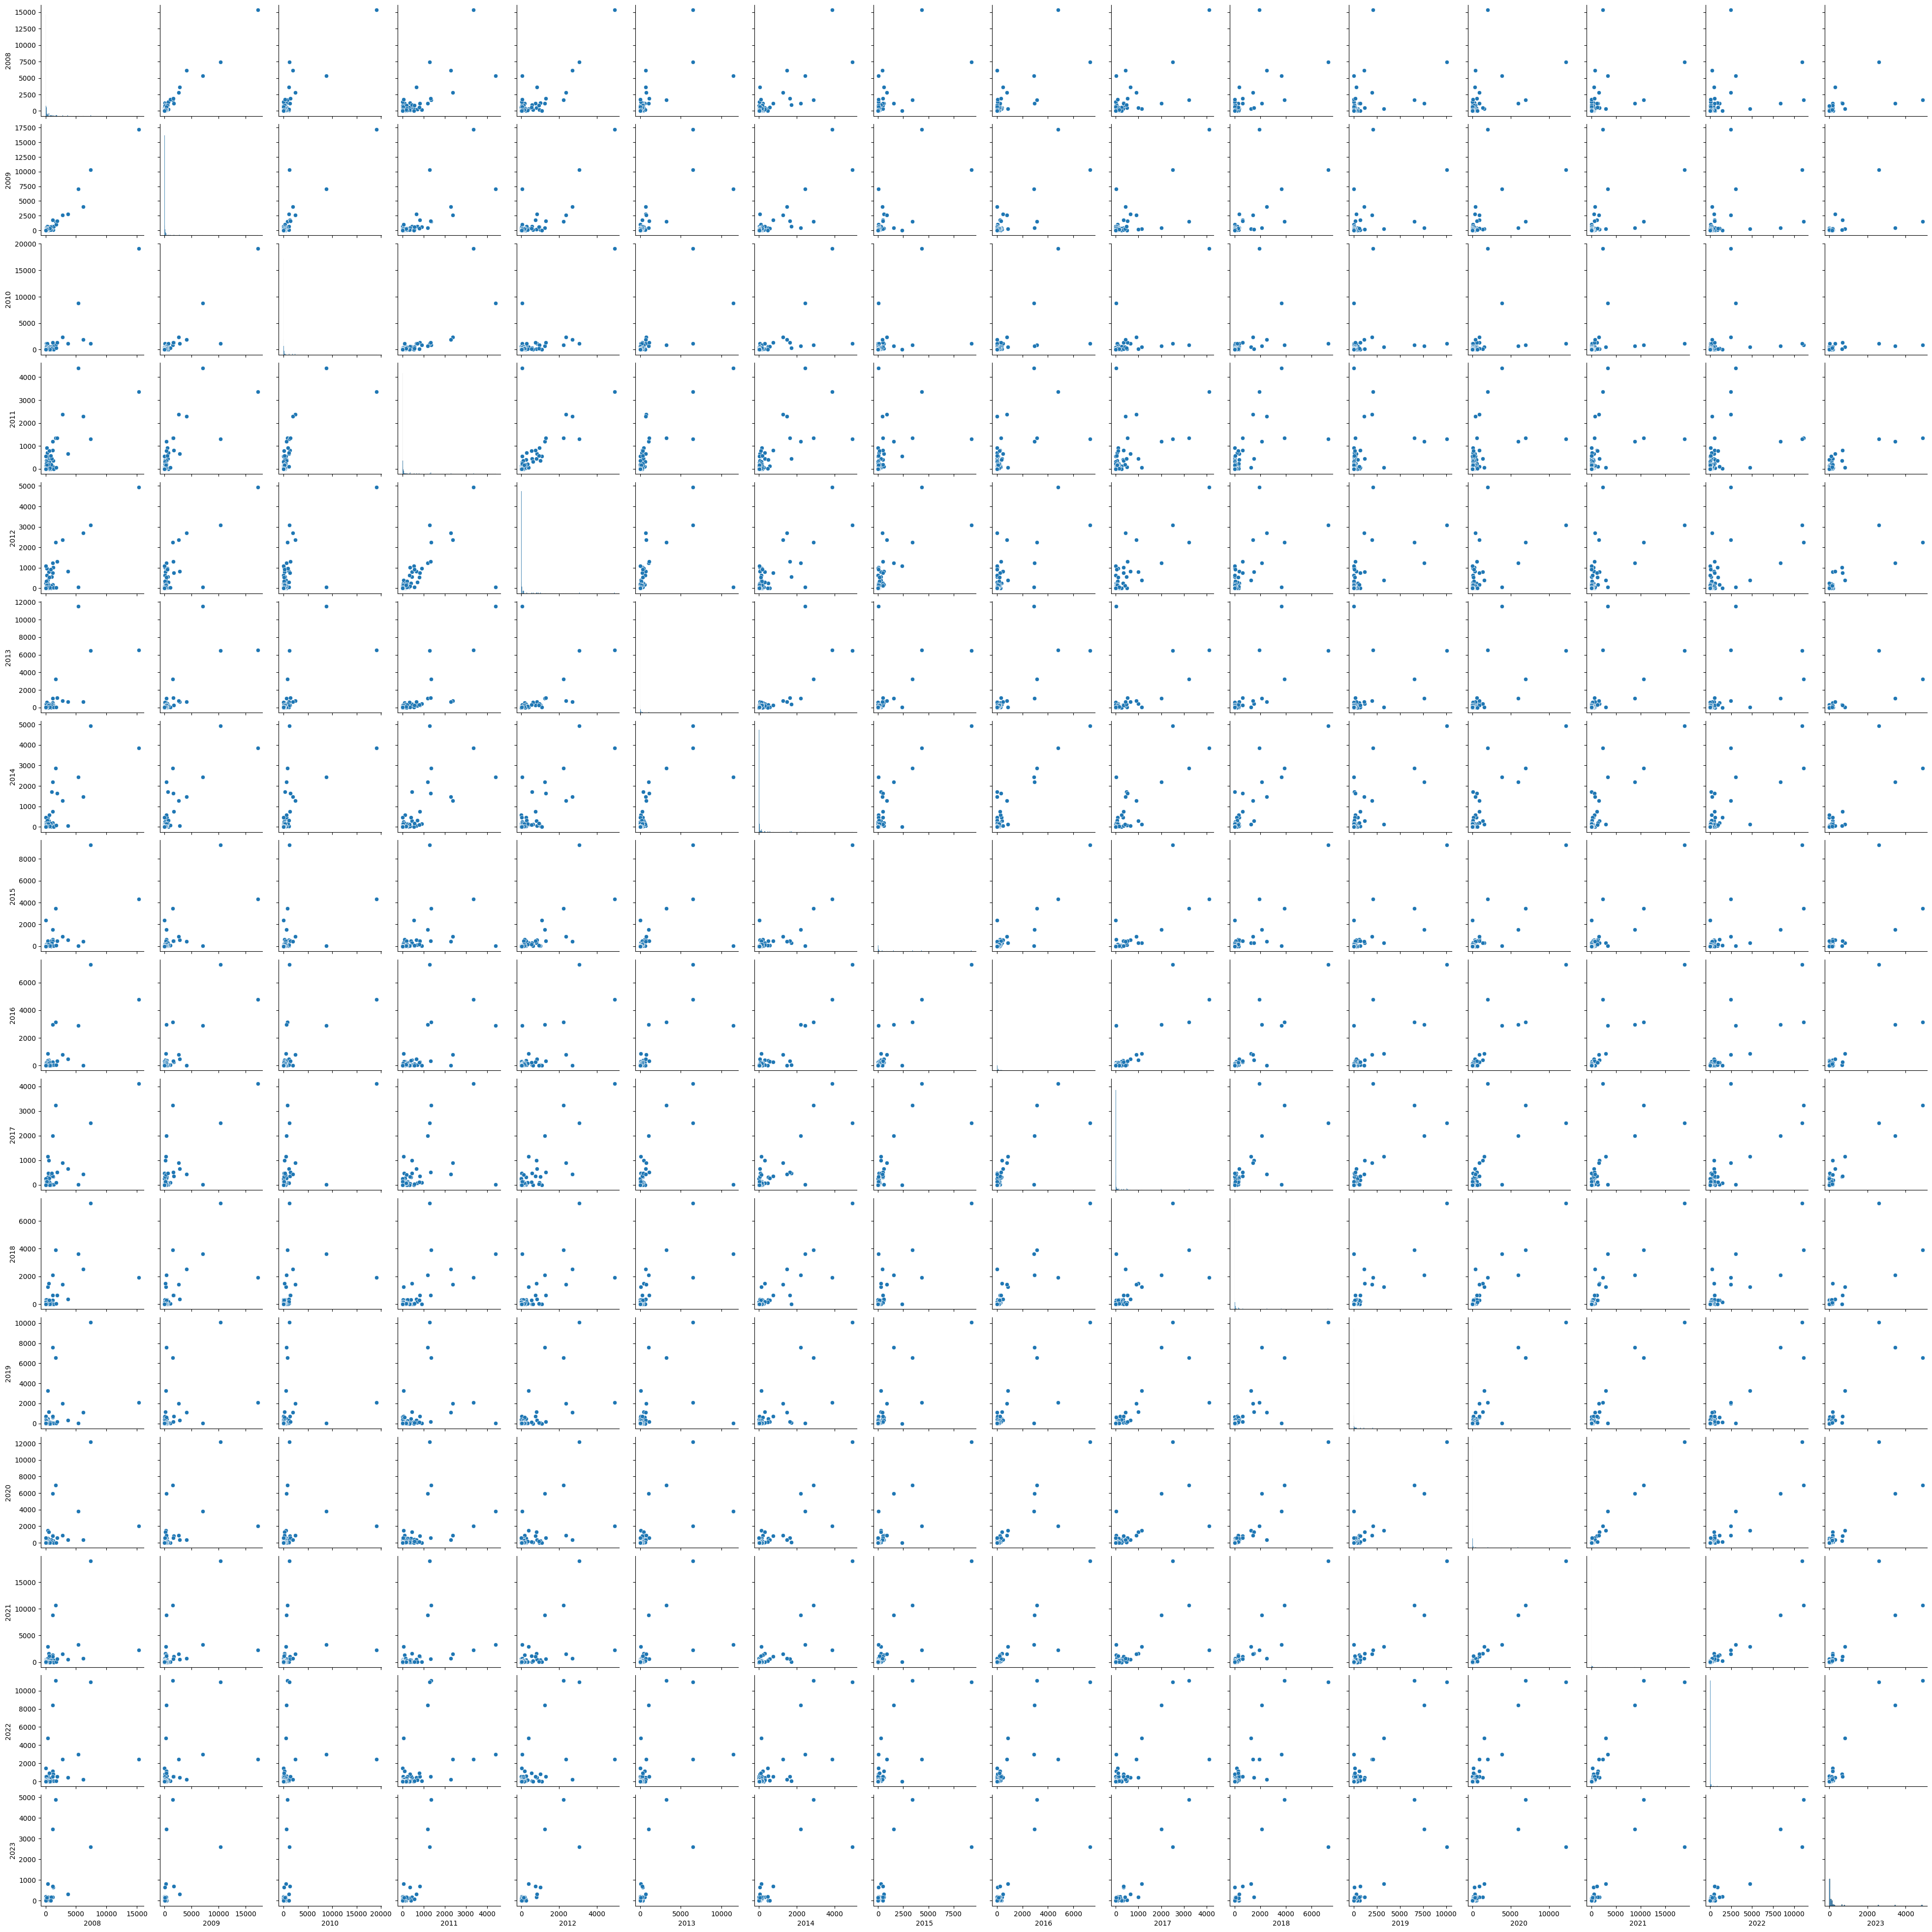

In [278]:
sns.pairplot(df[cols])

In [264]:
df[['área_ha_uc'] + cols].corr(method='spearman')

,área_ha_uc,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
área_ha_uc,1.000000,0.484352,0.351668,0.455890,0.519228,0.400261,0.453861,0.443828,0.355189,0.440184,0.491773,0.441879,0.589603,0.582882,0.607576,0.548148,0.433350
2008,0.484352,1.000000,0.787749,0.720600,0.703543,0.719700,0.724268,0.695426,0.665858,0.717103,0.637644,0.676514,0.639491,0.637624,0.643372,0.680509,0.553882
2009,0.351668,0.787749,1.000000,0.755218,0.669573,0.718393,0.708036,0.688149,0.739904,0.677596,0.625969,0.665994,0.583683,0.582579,0.605533,0.652998,0.543877
2010,0.455890,0.720600,0.755218,1.000000,0.742600,0.736987,0.711267,0.698821,0.689028,0.715014,0.654721,0.687744,0.658894,0.645979,0.662320,0.687582,0.502828
2011,0.519228,0.703543,0.669573,0.742600,1.000000,0.821546,0.718904,0.701549,0.679410,0.673162,0.709758,0.701373,0.663832,0.716261,0.709742,0.765635,0.658297
2012,0.400261,0.719700,0.718393,0.736987,0.821546,1.000000,0.813759,0.708592,0.742008,0.742926,0.698931,0.682151,0.630015,0.646531,0.640059,0.676945,0.685319
2013,0.453861,0.724268,0.708036,0.711267,0.718904,0.813759,1.000000,0.694480,0.724434,0.700175,0.654714,0.649011,0.618876,0.676053,0.660276,0.671541,0.717350
2014,0.443828,0.695426,0.688149,0.698821,0.701549,0.708592,0.694480,1.000000,0.728975,0.694767,0.699377,0.690336,0.621412,0.638009,0.638385,0.689870,0.606319
2015,0.355189,0.665858,0.739904,0.689028,0.679410,0.742008,0.724434,0.728975,1.000000,0.777711,0.703191,0.688365,0.671658,0.640604,0.661701,0.692024,0.707666
2016,0.440184,0.717103,0.677596,0.715014,0.673162,0.742926,0.700175,0.694767,0.777711,1.000000,0.741750,0.749192,0.723362,0.681635,0.678518,0.728122,0.675067


Como esperado, todas as colunas são extremamente correlacionadas entre si. E a que é geralmente menos correlacionada com outras é 'área_ha_uc', o que significa que o tamanho da UC de fato importa para a quantidade de seus hecctares desmatados, mas não tanto.

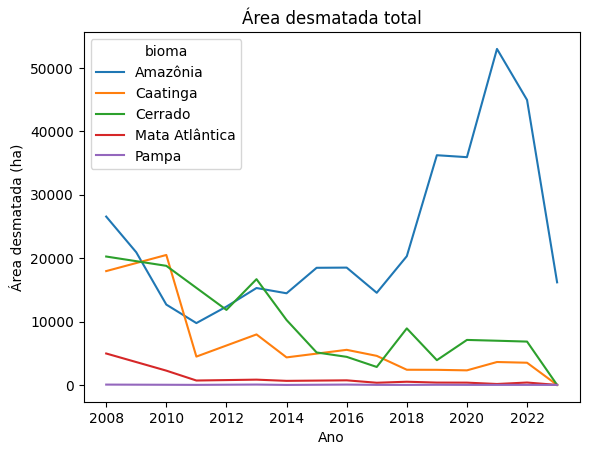

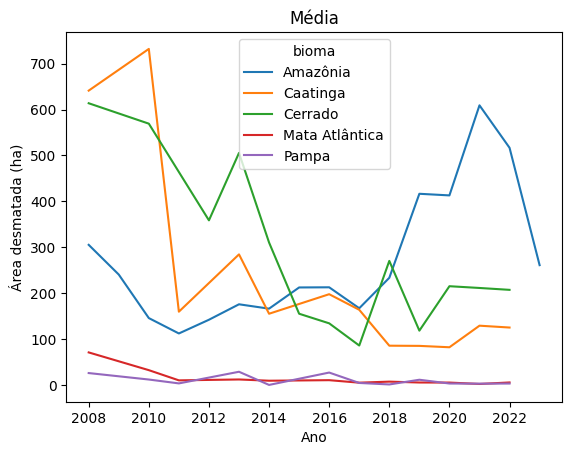

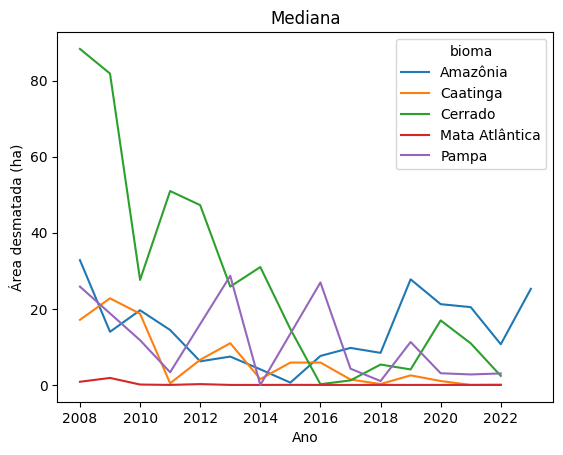

In [265]:
colsb = cols + ['bioma']
grupobi = df[colsb].groupby(by='bioma')
#sns.lineplot(df[colsb].groupby(by='bioma').aggregate('mean').T)

grupobi.aggregate('sum').T.plot.line()
plt.xlabel('Ano')
plt.ylabel('Área desmatada (ha)')
plt.title('Área desmatada total')

grupobi.aggregate('mean').T.plot.line()
plt.xlabel('Ano')
plt.ylabel('Área desmatada (ha)')
plt.title('Média')

grupobi.aggregate('median').T.plot.line()
plt.xlabel('Ano')
plt.ylabel('Área desmatada (ha)')
plt.title('Mediana');

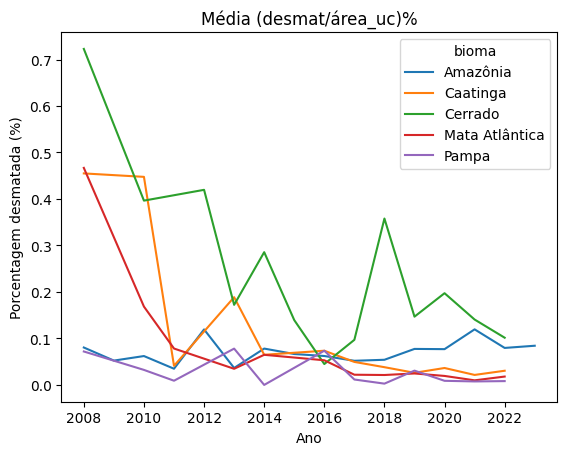

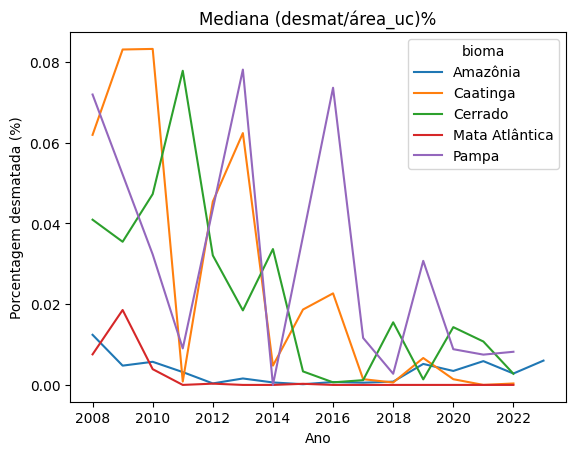

In [272]:
grupobi = dft[colsb].groupby(by='bioma')

(grupobi.aggregate('mean')*100).T.plot.line()
plt.xlabel('Ano')
plt.ylabel('Porcentagem desmatada (%)')
plt.title('Média (desmat/área_uc)%')

(grupobi.aggregate('median')*100).T.plot.line()
plt.xlabel('Ano')
plt.ylabel('Porcentagem desmatada (%)')
plt.title('Mediana (desmat/área_uc)%');

In [233]:
df[colsb].groupby(by='bioma').aggregate(['sum', 'median', 'mean']).T

bioma            Amazônia      Caatinga       Cerrado  Mata Atlântica    Pampa
2008 sum     26556.580000  17956.650000  20254.880000     4957.970000  51.6900
     median     32.810000     17.110000     88.340000        0.830000  25.8450
     mean      305.248046    641.308929    613.784242       70.828143  25.8450
2009 sum     20924.080000  19228.590000  19520.915000     3605.150000  37.6050
     median     13.970000     22.770000     81.860000        1.837500  18.8025
     mean      240.506667    686.735357    591.542879       51.502143  18.8025
2010 sum     12672.040000  20500.530000  18786.950000     2252.330000  23.5200
     median     19.630000     18.715000     27.610000        0.100000  11.7600
     mean      145.655632    732.161786    569.301515       32.176143  11.7600
2011 sum      9754.790000   4468.170000  15310.875000      695.000000   6.6400
     median     14.440000      0.425000     50.970000        0.000000   3.3200
     mean      112.124023    159.577500    463.965909        9.928571   3.3200
2012 sum     12355.390000   6216.645000  11834.800000      763.375000  32.0000
     median      6.200000      6.607500     47.270000        0.215000  16.0000
     mean      142.015977    222.023036    358.630303       10.905357  16.0000
2013 sum     15285.990000   7965.120000  16682.300000      831.750000  57.3600
     median      7.450000     10.970000     25.850000        0.000000  28.6800
     mean      175.701034    284.468571    505.524242       11.882143  28.6800
2014 sum     14456.560000   4342.970000  10240.070000      641.180000   0.0000
     median      4.100000      1.530000     30.990000        0.000000   0.0000
     mean      166.167356    155.106071    310.305152        9.159714   0.0000
2015 sum     18477.670000   4939.020000   5119.500000      682.355000  26.9400
     median      0.610000      5.877500     14.680000        0.015000  13.4700
     mean      212.387011    176.393571    155.136364        9.747929  13.4700
2016 sum     18506.560000   5535.070000   4428.900000      723.530000  53.8800
     median      7.620000      5.890000      0.190000        0.000000  26.9400
     mean      212.719080    197.681071    134.209091       10.336143  26.9400
2017 sum     14534.440000   4584.020000   2832.650000      343.250000   8.5500
     median      9.730000      1.420000      1.190000        0.000000   4.2750
     mean      167.062529    163.715000     85.837879        4.903571   4.2750
2018 sum     20305.810000   2393.420000   8917.710000      502.370000   2.0300
     median      8.430000      0.235000      5.360000        0.000000   1.0150
     mean      233.400115     85.479286    270.233636        7.176714   1.0150
2019 sum     36235.860000   2382.140000   3902.970000      367.930000  22.5700
     median     27.760000      2.510000      4.070000        0.000000  11.2850
     mean      416.504138     85.076429    118.271818        5.256143  11.2850
2020 sum     35929.220000   2297.930000   7097.800000      358.910000   6.1400
     median     21.230000      1.030000     16.960000        0.000000   3.0700
     mean      412.979540     82.068929    215.084848        5.127286   3.0700
2021 sum     53004.940000   3614.370000   6971.720000      146.290000   5.5100
     median     20.450000      0.000000     10.930000        0.000000   2.7550
     mean      609.252184    129.084643    211.264242        2.089857   2.7550
2022 sum     44954.360000   3501.240000   6836.630000      376.290000   6.0300
     median     10.690000      0.065000      2.380000        0.000000   3.0150
     mean      516.716782    125.044286    207.170606        5.375571   3.0150
2023 sum     16181.770000      0.000000      0.000000        0.000000   0.0000
     median     25.265000           NaN           NaN             NaN      NaN
     mean      260.996290           NaN           NaN             NaN      NaN

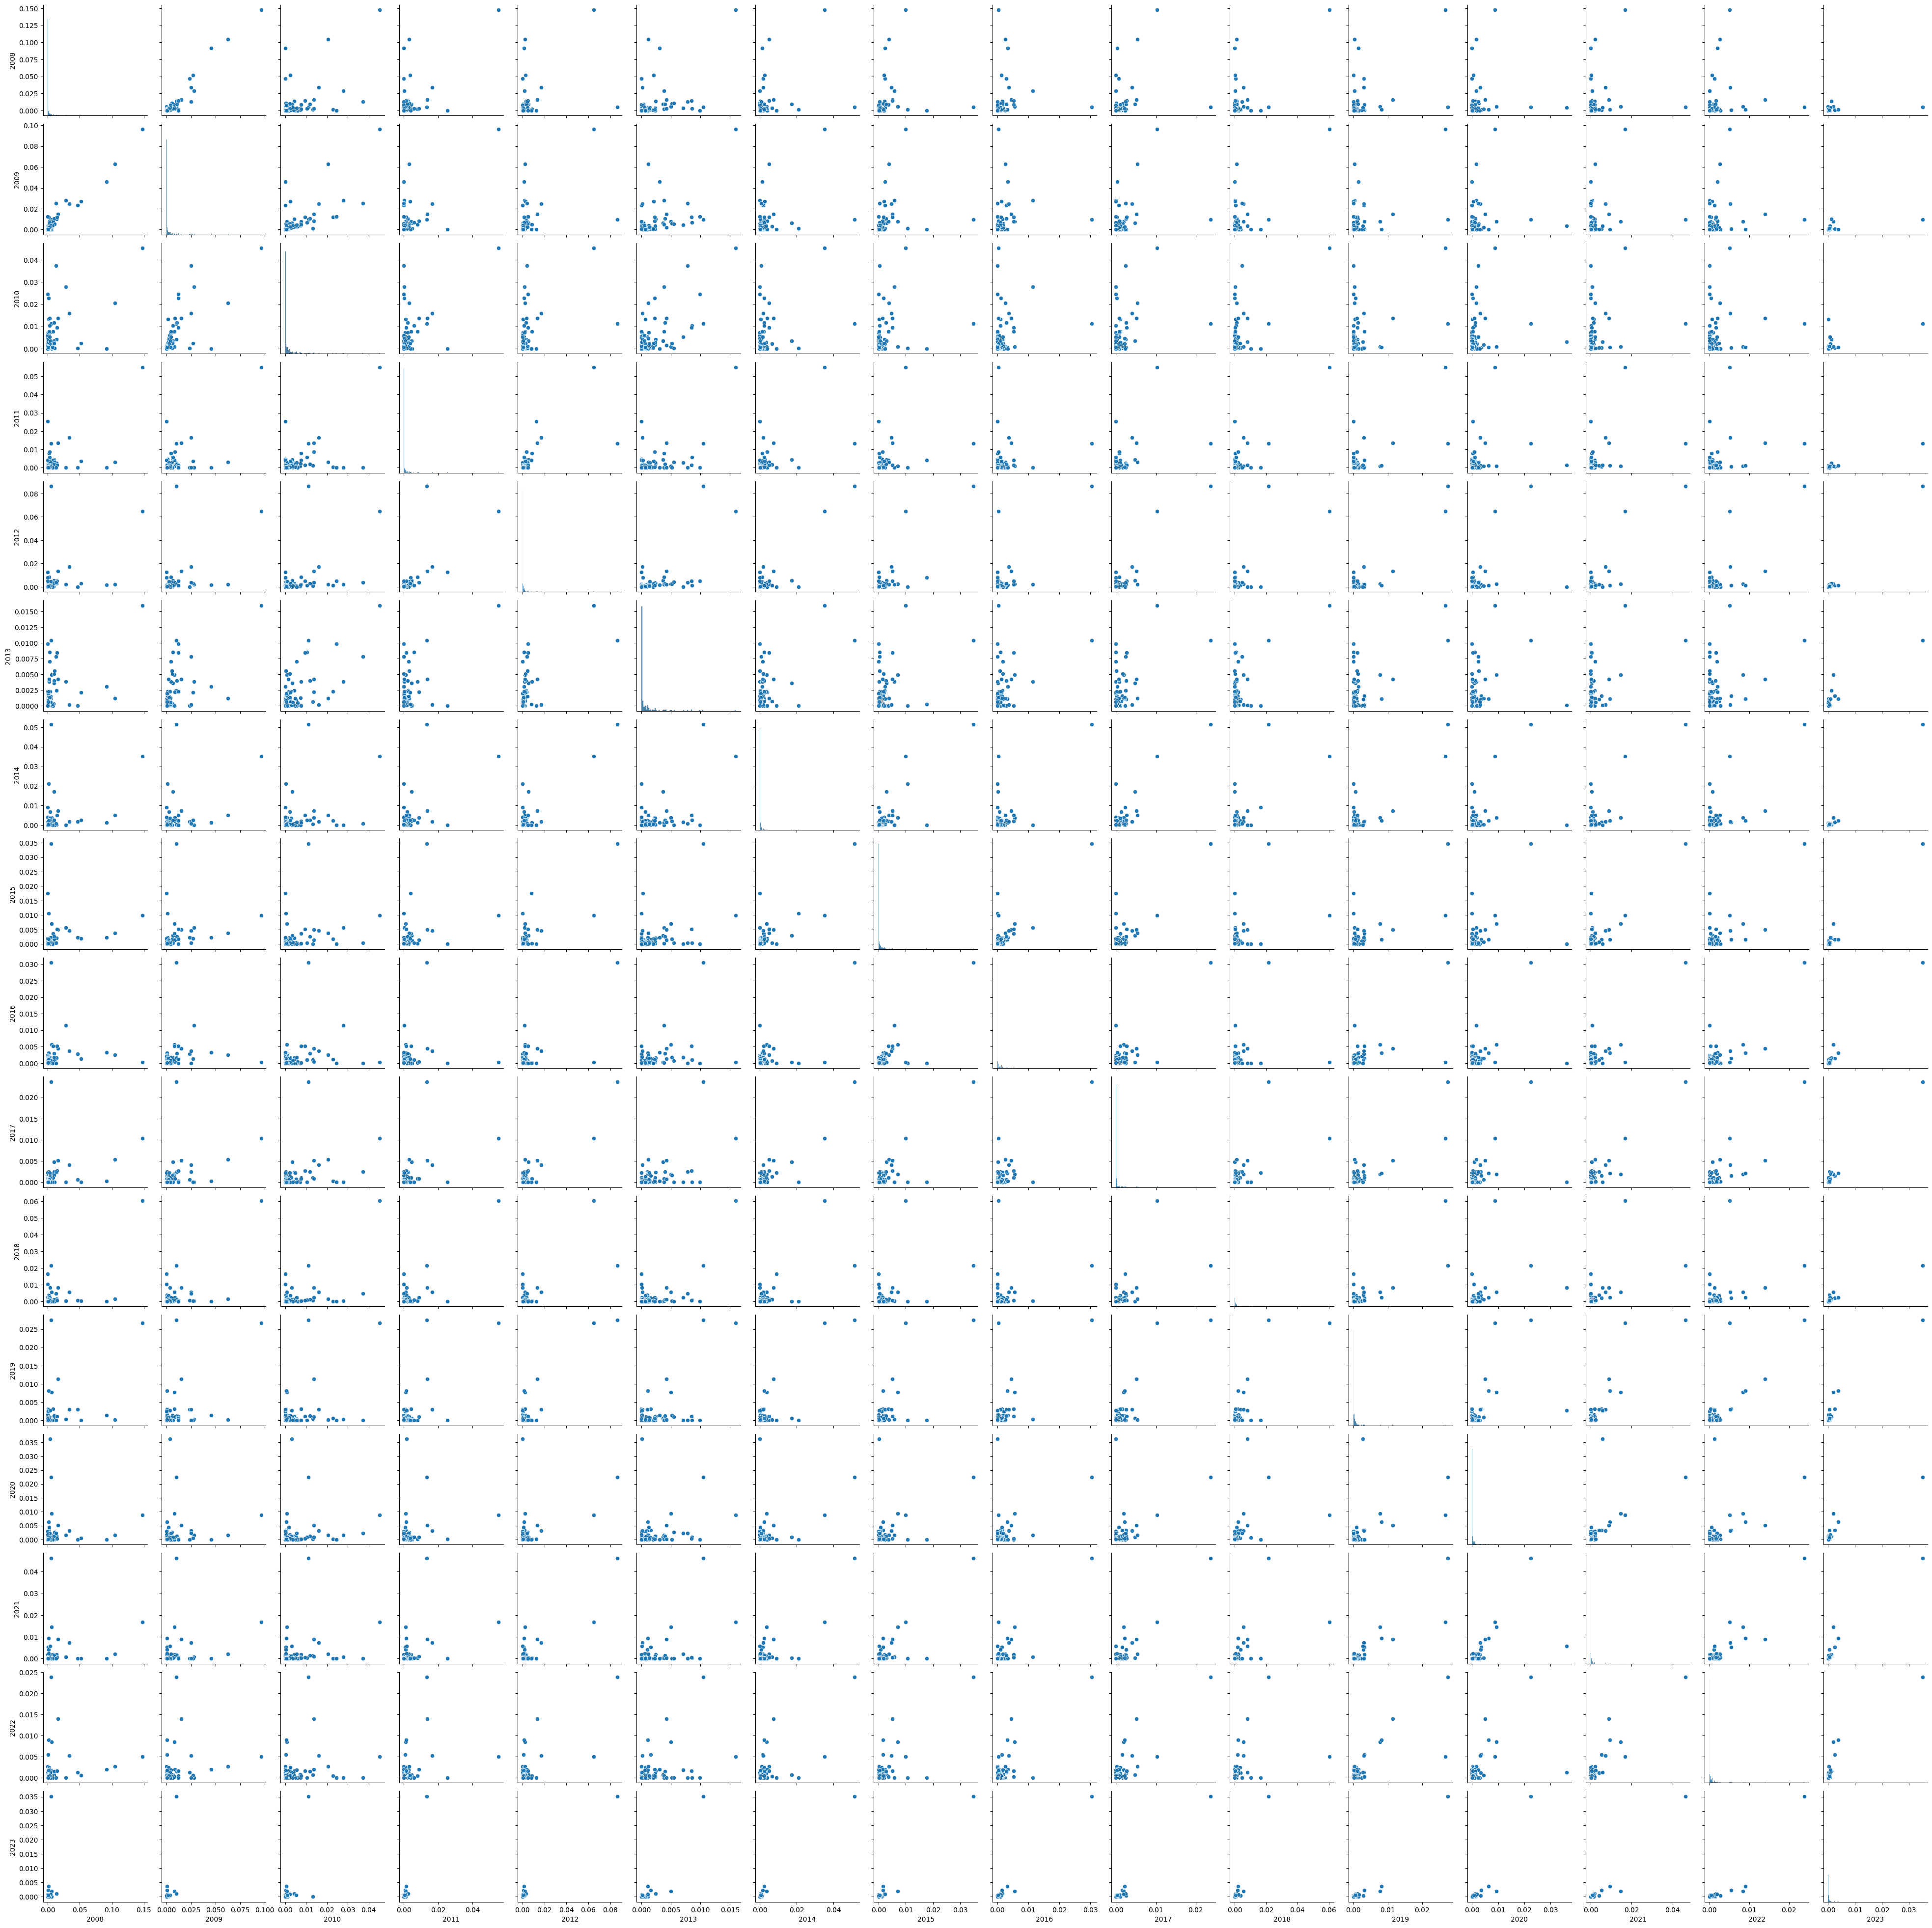

In [279]:
sns.pairplot(dft[cols])

In [284]:
df['área_ha_uc'].describe()

count    2.200000e+02
mean     2.858424e+05
std      5.417177e+05
min      8.918946e+01
25%      1.126207e+04
50%      6.754204e+04
75%      2.790140e+05
max      3.865169e+06
Name: área_ha_uc, dtype: float64

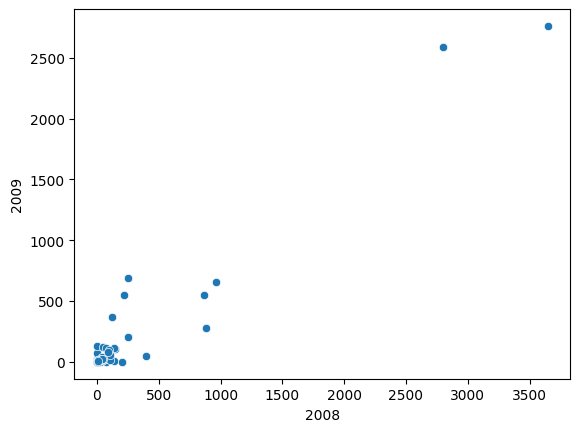

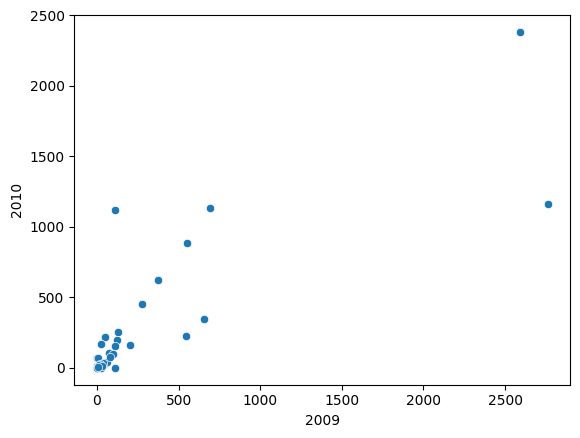

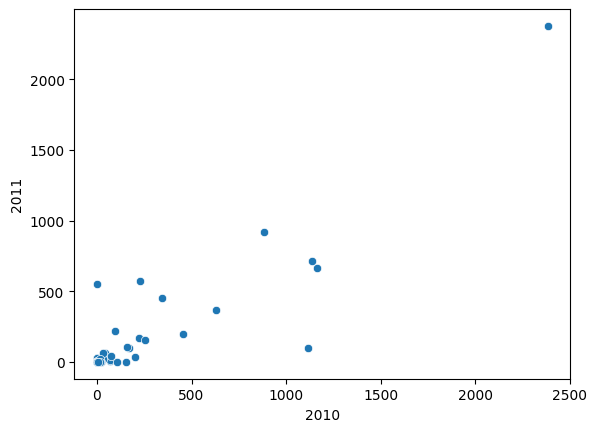

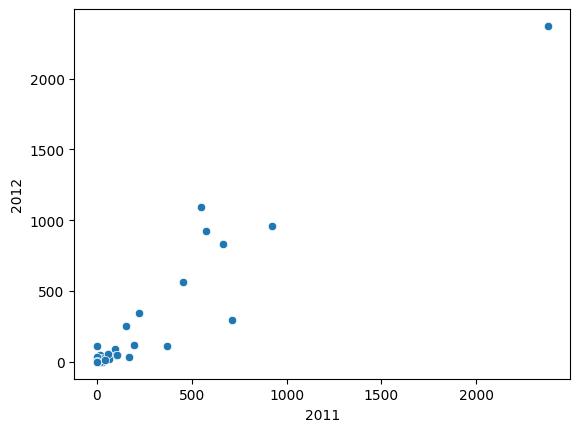

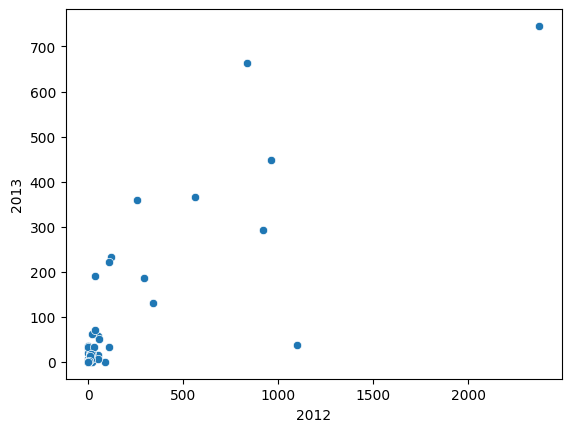

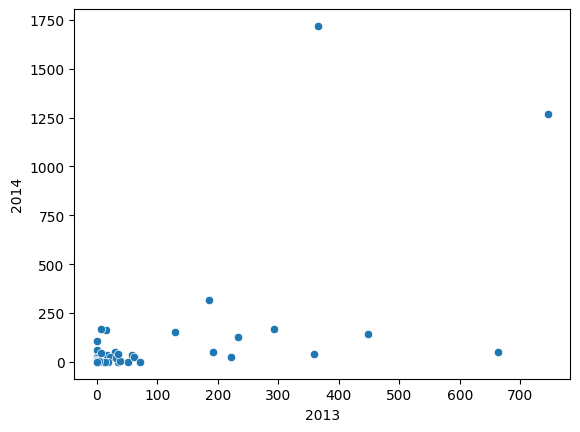

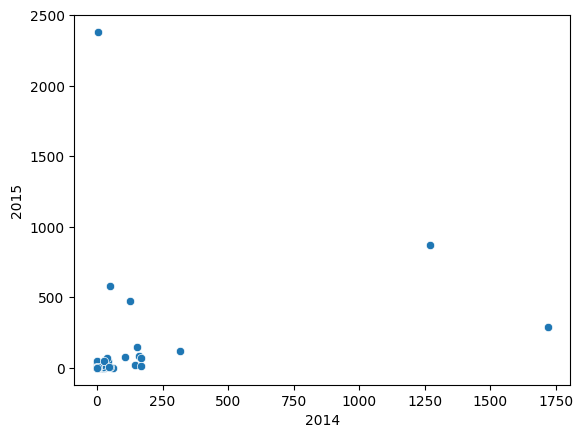

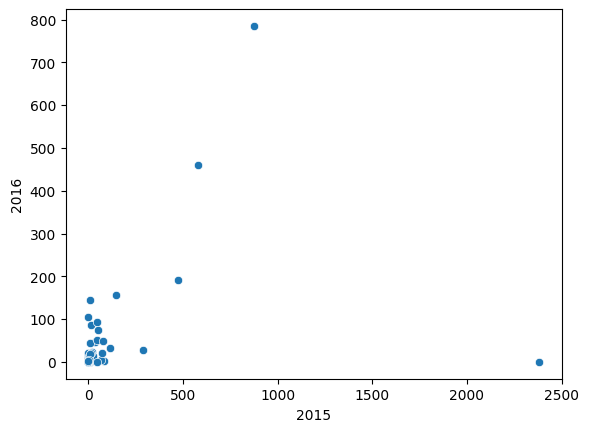

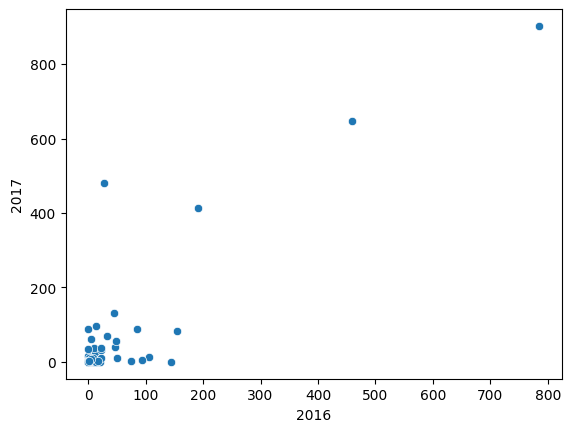

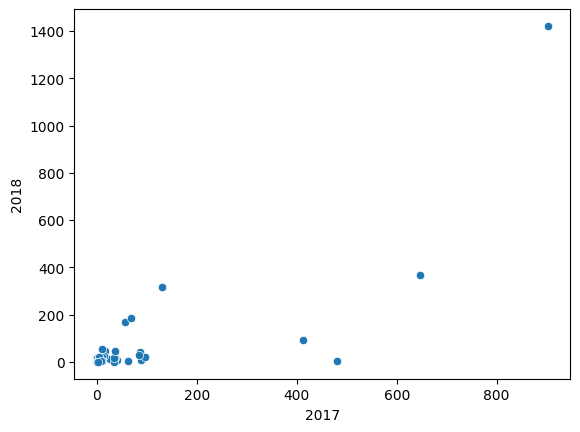

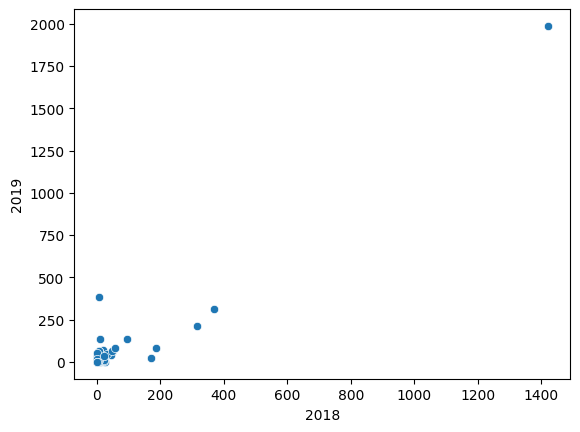

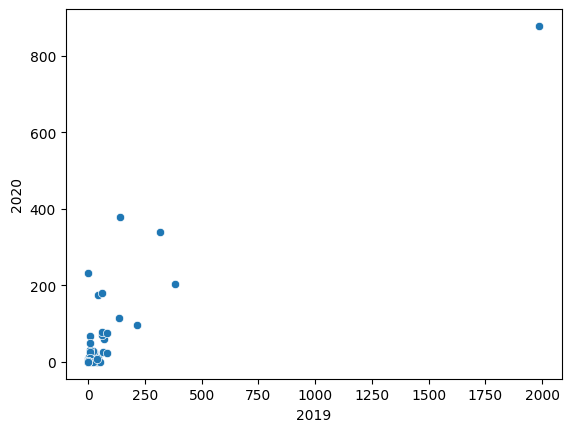

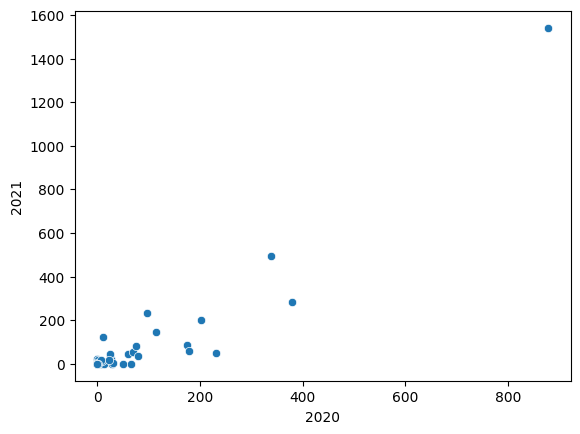

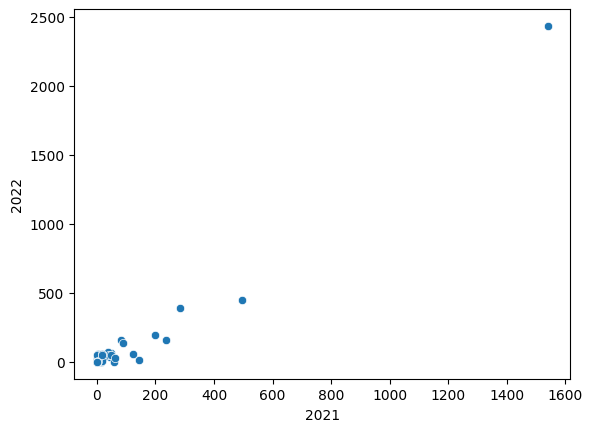

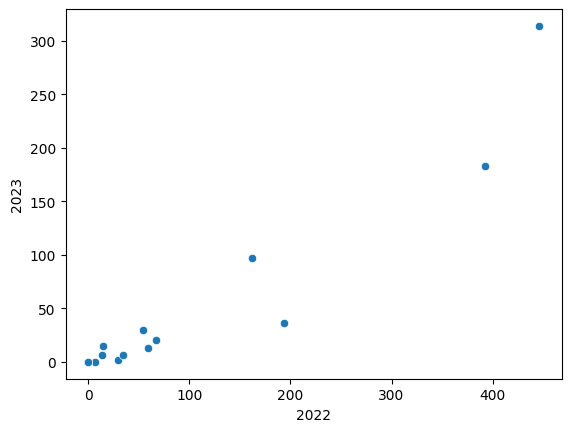

In [347]:
q1 = df['área_ha_uc'].quantile(q=0.25)
q2 = df['área_ha_uc'].median()
q3 = df['área_ha_uc'].quantile(q=0.75)

for i in range(2008, 2023):
  #sns.scatterplot(data=df.loc[(df['área_ha_uc'] <= q1), cols], x=i, y=i+1)
  #sns.scatterplot(data=df.loc[((df['área_ha_uc'] > q1) & (df['área_ha_uc'] <= q2)), cols], x=i, y=i+1)
  sns.scatterplot(data=df.loc[((df['área_ha_uc'] > q2) & (df['área_ha_uc'] <= q3)), cols], x=i, y=i+1)
  plt.show()

#sns.scatterplot(data=df.loc[(df['área_ha_uc'] <= q1), cols], x=2012, y=2014)

<Axes: xlabel='área_ha_uc', ylabel='Count'>

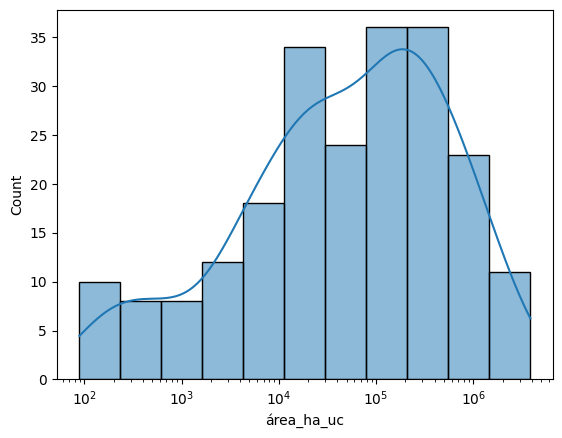

In [338]:
sns.histplot(df['área_ha_uc'], log_scale=True, kde=True)

In [337]:
#Shapiro-Wilk test de normalidade (valor,p-value)
valor, pvalue = stats.shapiro(df['área_ha_uc'].apply(log10))
print(f"{pvalue:.6f}")

0.000000


<Axes: >

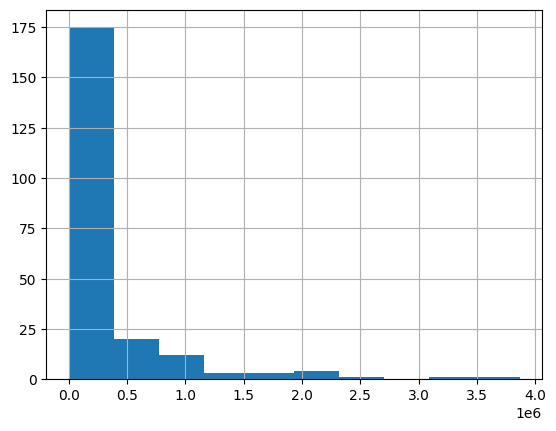

In [294]:
q = df['área_ha_uc'].quantile(q=0.75)
df['área_ha_uc'].hist()
#df.loc[(df['área_ha_uc'] >= q), 'área_ha_uc'].hist()
#df['área_ha_uc'].plot.kde()

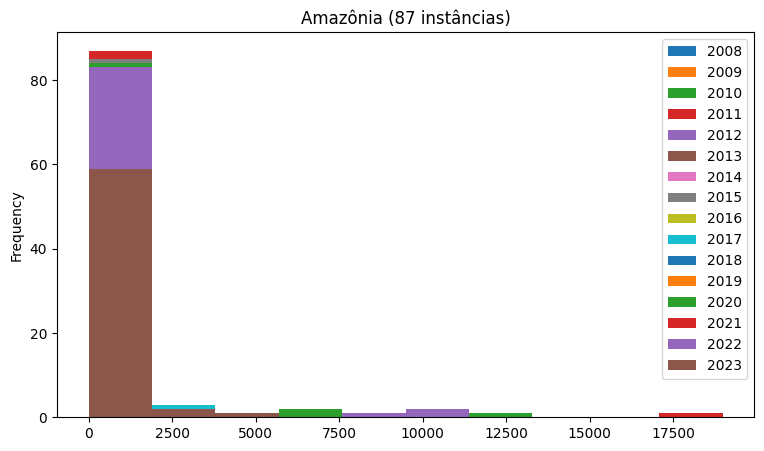

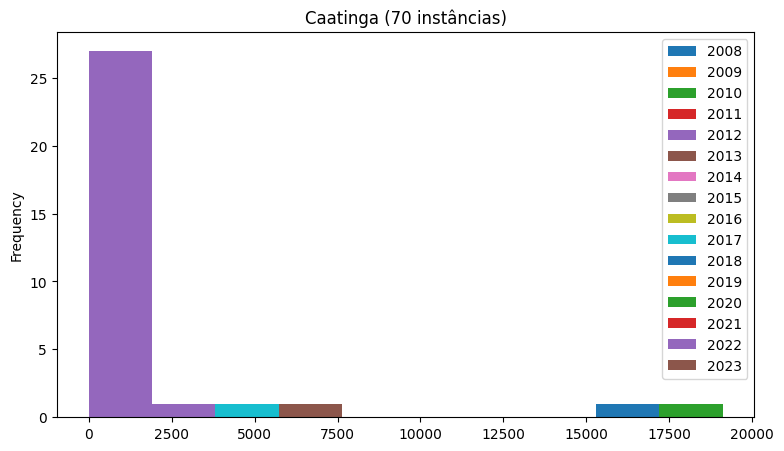

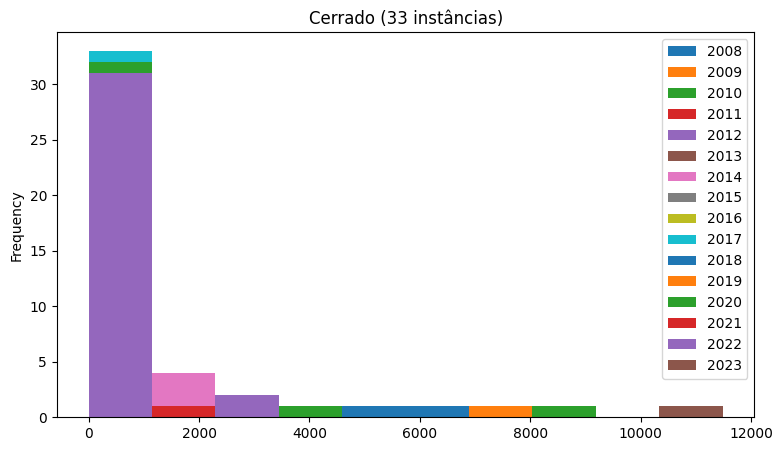

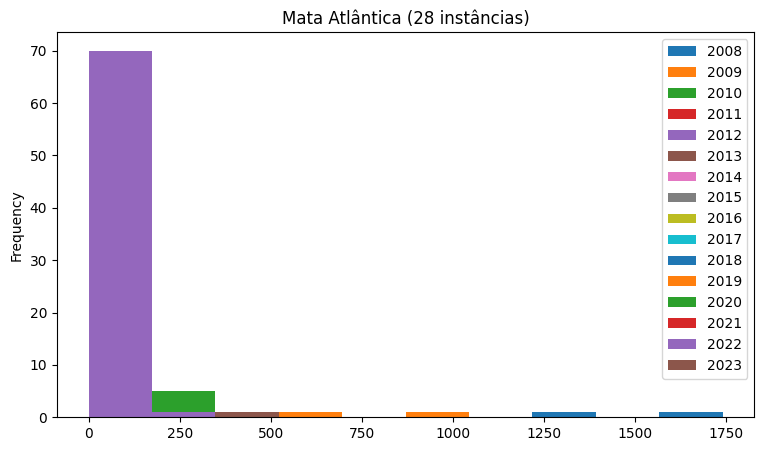

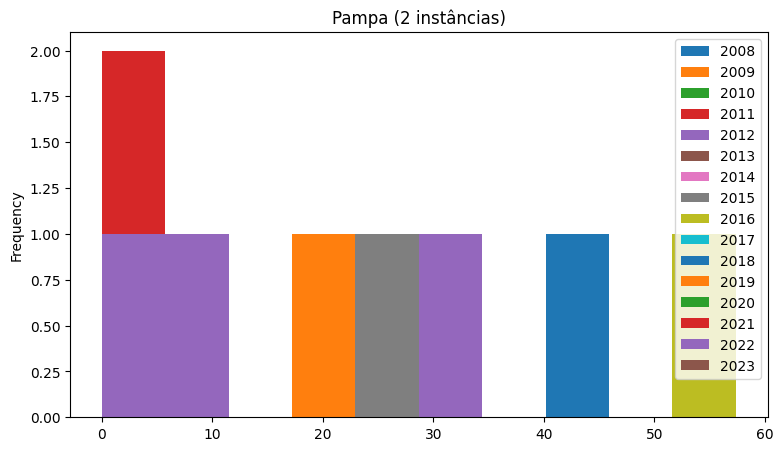

In [277]:
count = df.bioma.value_counts()

df.loc[(df.bioma.cat.codes==0), cols].plot.hist(figsize=(9,5))
plt.title(f"{df.bioma.cat.categories[0]} ({count[0]} instâncias)")
plt.show()
df.loc[(df.bioma.cat.codes==1), cols].plot.hist(figsize=(9,5))
plt.title(f"{df.bioma.cat.categories[1]} ({count[1]} instâncias)")
plt.show()
df.loc[(df.bioma.cat.codes==2), cols].plot.hist(figsize=(9,5))
plt.title(f"{df.bioma.cat.categories[2]} ({count[2]} instâncias)")
plt.show()
df.loc[(df.bioma.cat.codes==3), cols].plot.hist(figsize=(9,5))
plt.title(f"{df.bioma.cat.categories[3]} ({count[3]} instâncias)")
plt.show()
df.loc[(df.bioma.cat.codes==4), cols].plot.hist(figsize=(9,5))
plt.title(f"{df.bioma.cat.categories[4]} ({count[4]} instâncias)")
plt.show()

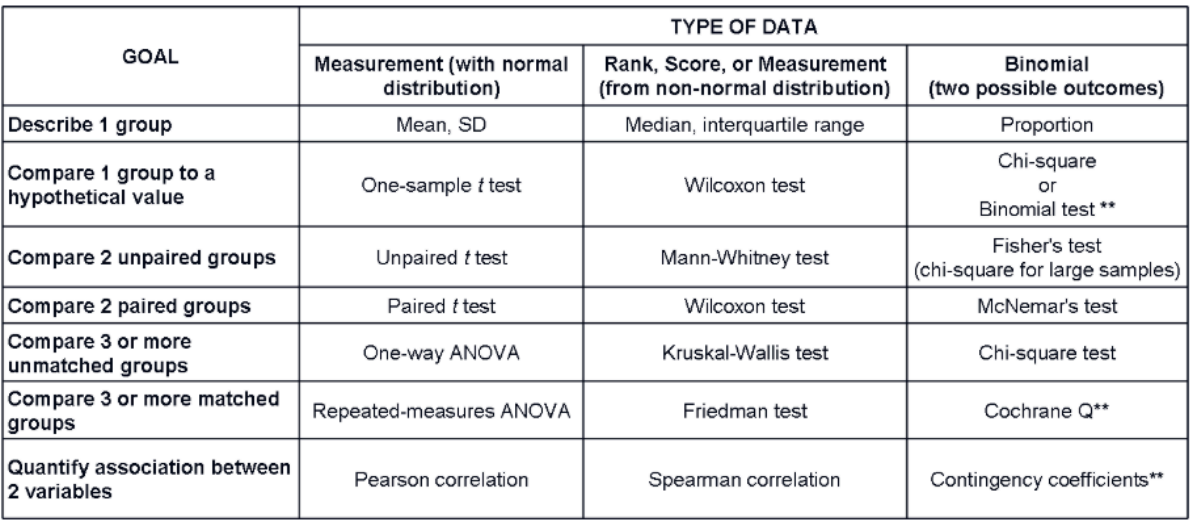

ShapiroResult(statistic=0.9379298090934753, pvalue=0.09791316837072372)

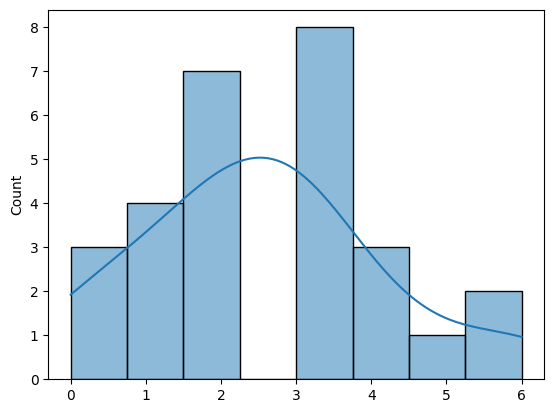

In [334]:
ggst = pd.Series([0, 0, 0,
                  1, 1, 1, 1,
                  2, 2, 2, 2, 2, 2, 2,
                  3, 3, 3, 3, 3, 3, 3, 3,
                  4, 4, 4,
                  5,
                  6, 6])

sns.histplot(ggst, kde=True)

stats.shapiro(ggst)